In [3]:
import csv#save and read data
from tqdm import tqdm#progress bar
import uproot3 as uproot
import uproot as uproot4
import numpy as np
import numba
import awkward as ak
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import rcParams
import mplhep as hep
plt.style.use(hep.style.ROOT)
import os,sys
import pandas as pd
from scipy.stats import halfnorm
from sklearn.cluster import KMeans
import random
from scipy.stats import binned_statistic
from scipy.stats import binned_statistic_2d
from scipy.optimize import curve_fit
from scipy.stats import crystalball
from lmfit import Model
import copy
import math
from scipy.stats import halfnorm
from sklearn.cluster import KMeans#clustering
from sklearn.cluster import Birch#clustering
from sklearn.mixture import GaussianMixture#clustering
from sklearn.cluster import DBSCAN#clustering
from scipy.stats import binned_statistic

In [4]:
# Process Data
def getData(fname="", procName="Events"):
    kn_dict = uproot.open(fname)["Events"].arrays()
    kn_dict_ak1 = {name.decode(): ak.from_awkward0(array) for name, array in kn_dict.items()}
    kn_events = ak.zip({"Electrons":ak.zip({
                                            "ge":      kn_dict_ak1["ge"],
                                            "gvx":      kn_dict_ak1["gvx"],
                                            "gvy":      kn_dict_ak1["gvy"],
                                            "gvz":      kn_dict_ak1["gvz"],
                                            "gpx":      kn_dict_ak1["gpx"],
                                            "gpy":      kn_dict_ak1["gpy"],
                                            "gpz":      kn_dict_ak1["gpz"],
                                        }),
                        "Hits":ak.zip({
                                      "detID":   kn_dict_ak1["hit_detID"],
                                      "edep":    kn_dict_ak1["hit_edep"],
                                      "elmID":   kn_dict_ak1["hit_elmID"],
                                      "truthx":  kn_dict_ak1["hit_truthx"],
                                      "truthy":  kn_dict_ak1["hit_truthy"],
                                      "truthz":  kn_dict_ak1["hit_truthz"],
                                      "hit_pos":  kn_dict_ak1["hit_pos"],
                                      }),
                        "St23_Tracklet":ak.zip({
                                        "st23tracklet_x_st1":   kn_dict_ak1["st23tracklet_x_st1"],
                                        "st23tracklet_x_st3":   kn_dict_ak1["st23tracklet_x_st3"],
                                        "st23tracklet_y_st1":   kn_dict_ak1["st23tracklet_y_st1"],
                                        "st23tracklet_y_st3":   kn_dict_ak1["st23tracklet_y_st3"],
                                        }),
                        "track":ak.zip({
                                      "x":   kn_dict_ak1["track_x_CAL"],
                                      "y":    kn_dict_ak1["track_y_CAL"],
                                      "ID":    kn_dict_ak1["eventID"],
                            
                                      }),
                       }, depth_limit=1)
    return kn_events

In [5]:
def emcal_simhit_selection(arr):
    mask = (arr.detID == 100)
    return mask

def emcal_simhit_selection_energy(arr, e):
    mask = (arr.edep >= e)
    return mask

def h2_selection(arr):
    mask = (arr.detID >= 35) & (arr.detID <= 38)
    return mask

def st2_selection(arr):
    mask = (arr.detID >= 13) & (arr.detID <= 18)
    return mask

def st3_selection(arr):
    mask = (arr.detID >= 19) & (arr.detID <= 30)
    return mask

def h4_selection(arr):
    mask = (arr.detID >= 41) & (arr.detID <= 46)
    return mask

In [6]:
ntowersx=72
ntowersy=36
sizex=5.53 # in cm
sizey=5.53 # in cm
ecalx=[-200,200] #size in cm
ecaly=[-100,100]
binsx=ecalx[1]- ecalx[0]
binsy=ecaly[1]- ecaly[0]
sfc = 0.1146337964120158 #sampling fraction of emcal
emin=0.0005
directory="/Users/wongdowling/Desktop/DQ_Dowling/samples"

In [7]:
def emcal_bytuple(file):
    dq_events = getData(file,"Events")
    x_pos = []#designed to be 2D
    y_pos = []#designed to be 2D
    eve_energy = []#designed to be 2D
    for i in range(len(dq_events[:]["Hits"].edep)):
        output=emcal_byevent(dq_events, i)
        if(len(output[0])!=0):
            x_pos.append(output[0])
            y_pos.append(output[1])
            eve_energy.append(output[2])
    return x_pos, y_pos, eve_energy

In [8]:
def emcal_byevent(dq_events,evtNum):
    dq_hits = dq_events[evtNum]["Hits"]
    # select emcal hits
    emcal_mask = emcal_simhit_selection(dq_hits)
    emcal_hits = dq_hits[emcal_mask]
    emcal_energy_mask = emcal_simhit_selection_energy(emcal_hits, emin)
    emcal_hits = emcal_hits[emcal_energy_mask]
    #convert into coordinates and energy_dp
    emcal_towerx = emcal_hits.elmID//ntowersy
    emcal_towery = emcal_hits.elmID%ntowersy
    emcal_x = ecalx[0]+emcal_towerx*sizex
    emcal_y = ecaly[0]+emcal_towery*sizey
    emcal_edep = emcal_hits.edep/sfc
    return emcal_x, emcal_y, emcal_edep

In [9]:
def find_lead_clus(label, eve_num, eng_eve):
    count=[0]*(len(np.unique(label)))
    for i in range(len(label)):
        count[label[i]]+=eng_eve[eve_num][i]
    return np.argmax(count)

In [10]:
def Clustering_tuple(file):
    output=emcal_bytuple(file)
    x_eve=output[0]
    y_eve=output[1]
    eng_eve=output[2]
    labels=[]#2D, for all hits
    lead_nums=[]#for each event
    for i in range(len(eng_eve)):
        coordinate=np.column_stack((x_eve[i],y_eve[i]))
        brc = Birch(threshold=20, n_clusters=None)#maximum radius of a cluster is 20, no limit on how much clusters
        brc.fit(coordinate)
        label=brc.predict(coordinate)
        labels.append(label)
        lead_nums.append(find_lead_clus(label, i, eng_eve))
    return labels, lead_nums, x_eve, y_eve, eng_eve

In [11]:
def find_coord(file):
    output=Clustering_tuple(file)
    labels=output[0]
    lead_nums=output[1]
    x_eve=output[2]
    y_eve=output[3]
    eng_eve=output[4]
    new_x=[]
    new_y=[]
    new_eng=[]
    for i in range(len(lead_nums)):
        x_1d=[]
        y_1d=[]
        eng_1d=[]
        for j, k in enumerate(labels[i]):
            if (k==lead_nums[i]):
                x_1d.append(x_eve[i][j])
                y_1d.append(y_eve[i][j])
                eng_1d.append(eng_eve[i][j])
        new_x.append(x_1d)
        new_y.append(y_1d)
        new_eng.append(eng_1d)
    return new_x, new_y, new_eng

In [12]:
def gen_center(file):
    output=find_coord(file)
    x_eve=output[0]
    y_eve=output[1]
    eng_eve=output[2]
    wew_x = []
    wew_y = []
    wid_x = []
    wid_y = []
    for i in range(len(eng_eve)):
        eng_tot=sum(eng_eve[i])
        wew_x.append(np.dot(x_eve[i], eng_eve[i])/eng_tot)
        wew_y.append(np.dot(y_eve[i], eng_eve[i])/eng_tot)
        try:wid_x.append(sum(x_eve[i])/len(x_eve[i]))
        except: wid_x.append([])
        try:wid_y.append(sum(y_eve[i])/len(y_eve[i]))
        except: wid_y.append([])
    return wew_x, wew_y, wid_x, wid_y
            

In [13]:
def track_bytuple(file):
    track_x = []
    track_y = []
    dq_events = getData(file,"Events")
    evtID = dq_events["track"].ID
    for evtNum in range (len(evtID)):
        dq_track = dq_events[evtNum]['track']
        track_x.append(dq_track.x)
        track_y.append(dq_track.y)
    return track_x, track_y

In [14]:
def matchup(file):
    output1 = gen_center(file)
    output2 = track_bytuple(file)
    wew_x = output1[0]
    wew_y = output1[1]
    wid_x = output1[2]
    wid_y = output1[3]
    track_x = output2[0]
    track_y = output2[1]
    hist = []
    diff_x = []
    diff_y = []
    for i in range(len(track_x)):
        diff_x.append(track_x[i]-wew_x[i])
        diff_y.append(track_y[i]-wew_y[i])
    diff_x = ak.flatten(diff_x)
    diff_y = ak.flatten(diff_y)
    return diff_x, diff_y

In [15]:
def track_match(file):
    input=file.split('_')
    output= matchup(file)
    diff_x = ak.to_list(output[0])
    diff_y = ak.to_list(output[1])
    fig, ax = plt.subplots()
    h = ax.hist2d(diff_x, diff_y, bins=(100, 100), range = [(-20,20), (-20,20)],density=False, cmap=plt.cm.jet)
    fig.colorbar(h[3], ax=ax)
    plt.xlabel('difference in x')
    plt.ylabel('difference in y')
    plt.title('track center-EW center for %s'%input[0])
    plt.savefig("Difference EW&track %s @%s"%(input[0],input[1]))
    plt.show()
    


In [24]:
def EnergyCluster(file):
    input=file.split('_')
    engclus=find_coord(file)[2]
    engevt=[]
    for i in engclus:
        engevt.append(sum(i))
    plt.hist(engevt, bins=120, range=(0,120), histtype='step', density=False, color="blue")
    plt.title('Energy distribution of leading cluster for %s'%input[1])
    plt.ylabel("# of evts out of 10000")
    plt.xlabel("Total energy of leading cluster [GeV]")
    plt.savefig("Energy distribution for %s"%input[1])
    plt.show()

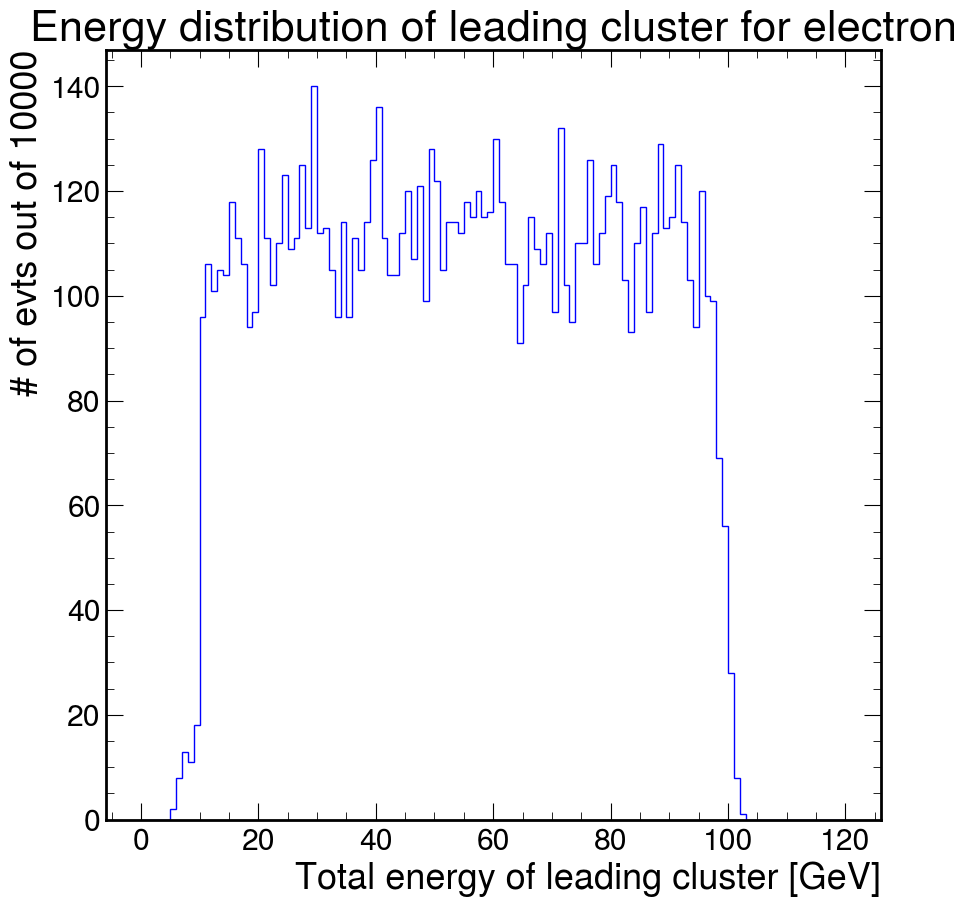

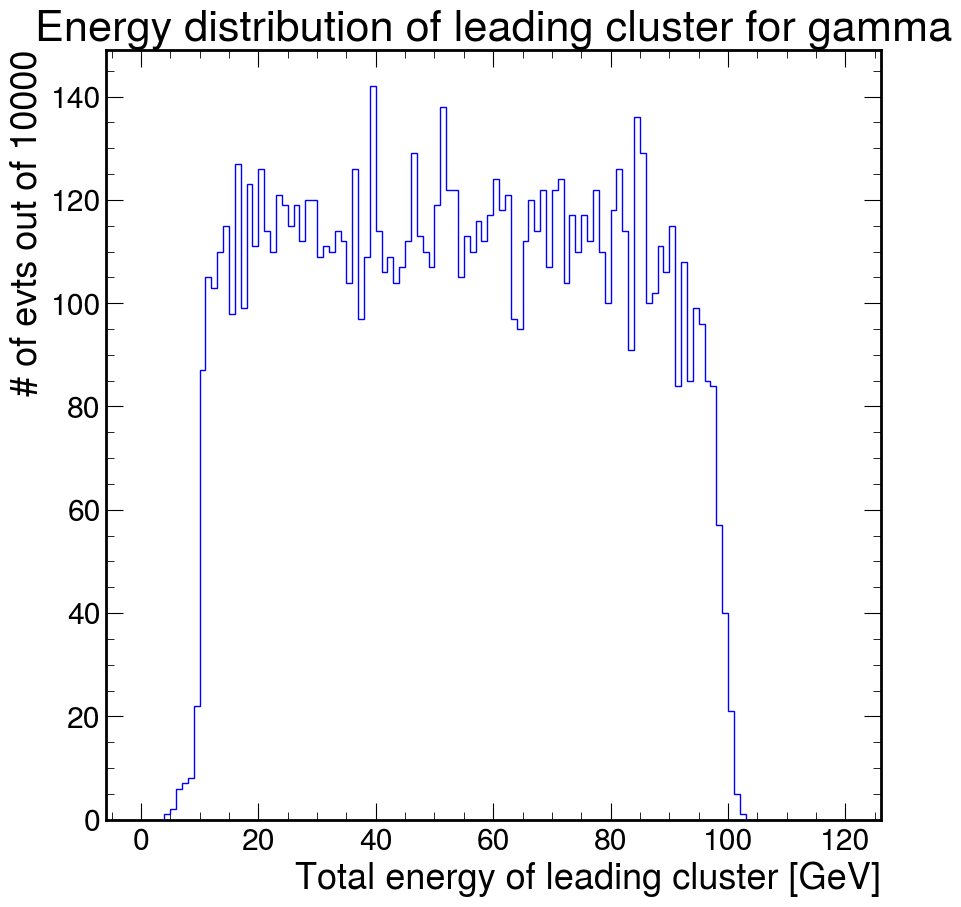

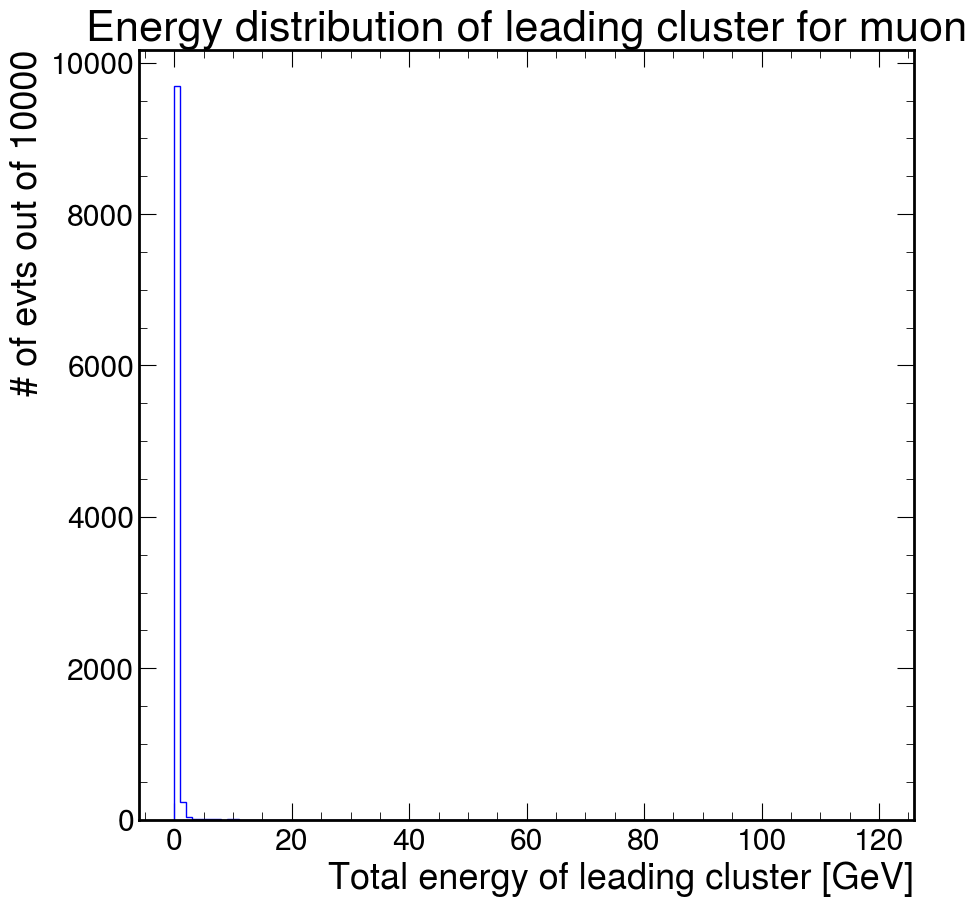

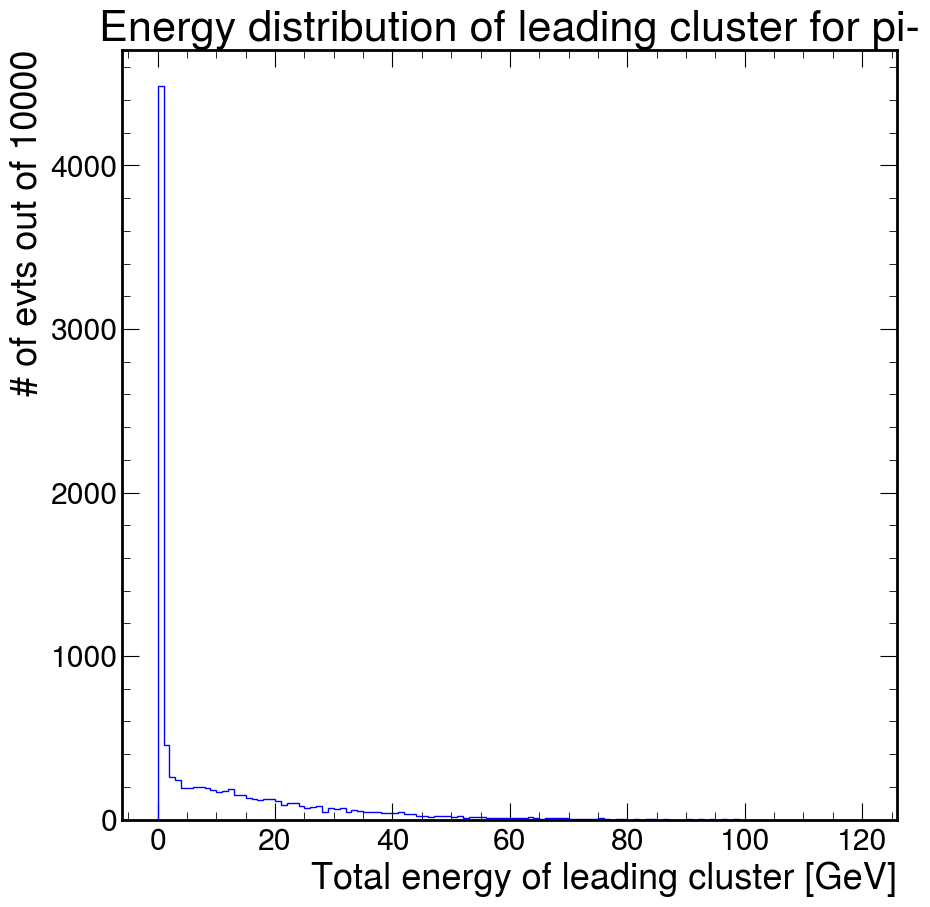

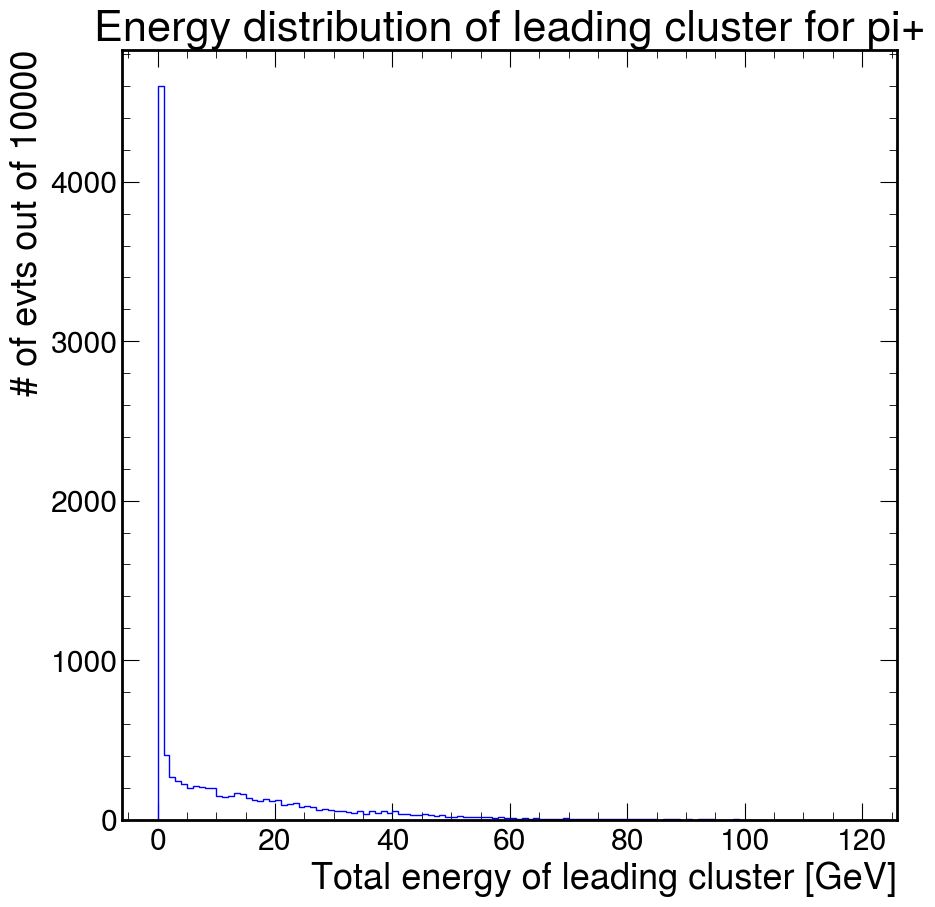

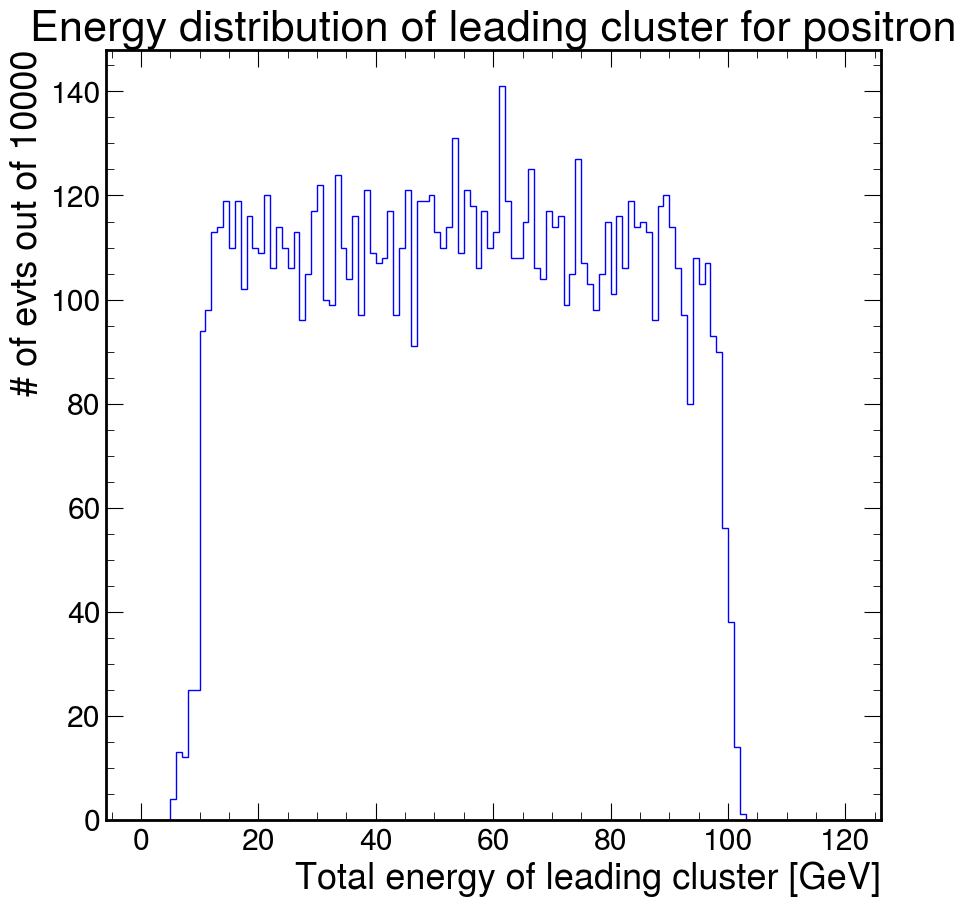

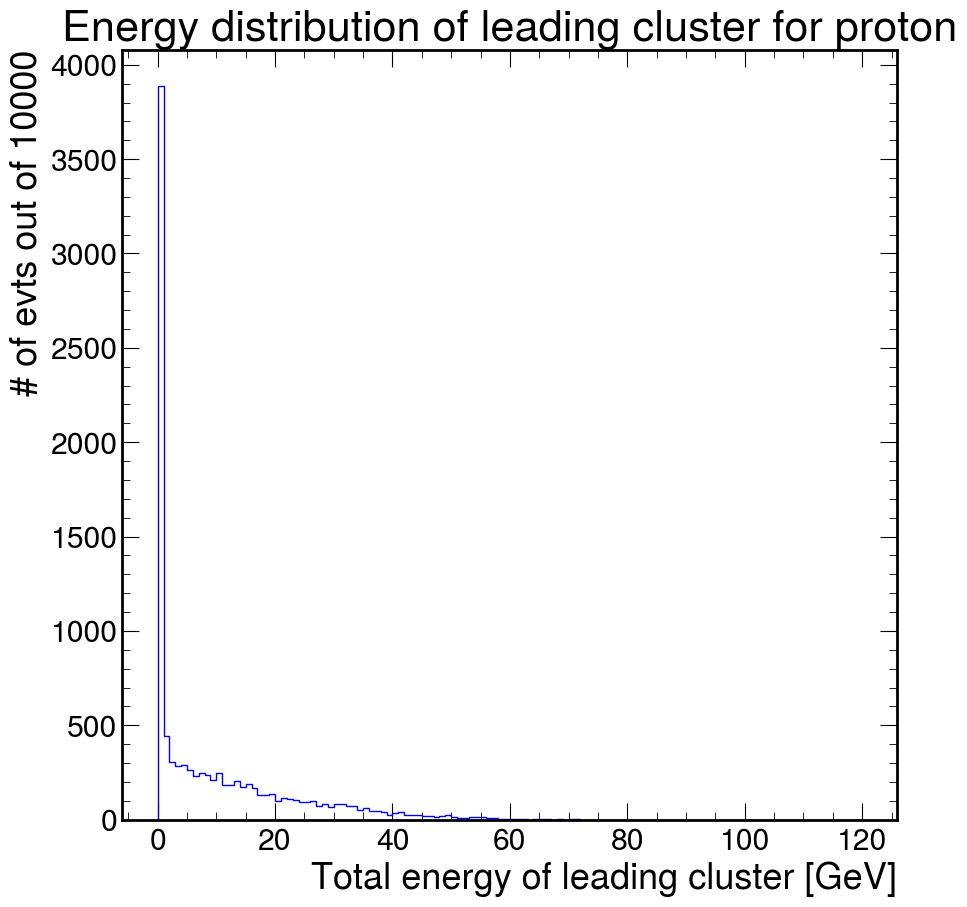

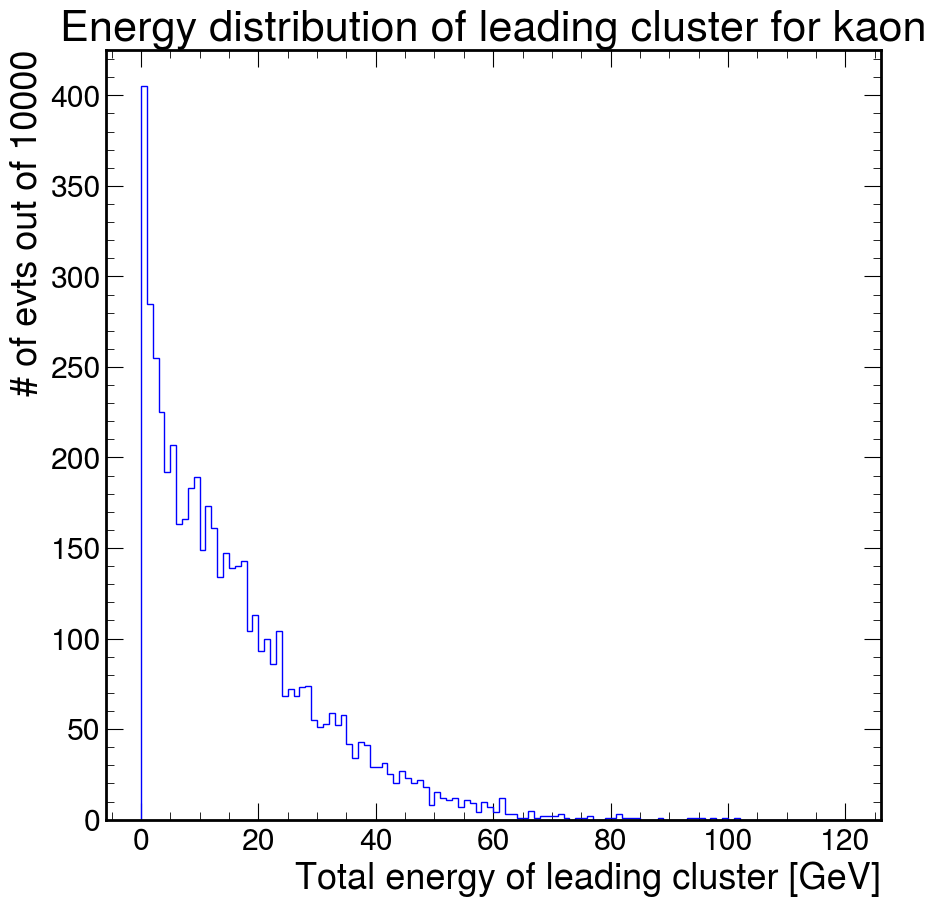

In [26]:
files=["st23_electron_520_10000eve.root", "st23_gamma_520_10000eve.root", "st23_muon_520_10000eve.root", "st23_pi-_520_10000eve.root", "st23_pi+_520_10000eve.root", "st23_positron_520_10000eve.root", "st23_proton_520_10000eve.root", "st23_kaon_520_10000eve.root"]
for x in files:
    EnergyCluster(x)


In [ ]:
engclus=find_coord(files[2])[2]
print(engclus)

In [69]:
def EngDiffLayers(file):
    #split leading clusters with their edep
    interval1=[0, 25, 50, 75, 105]# electron, photon, pi0, positron
    interval2=[0, 15, 30, 45, 60]#pi+, pi-, proton
    

In [80]:
out=Clustering_tuple(file)[2]
print(len(out))

529


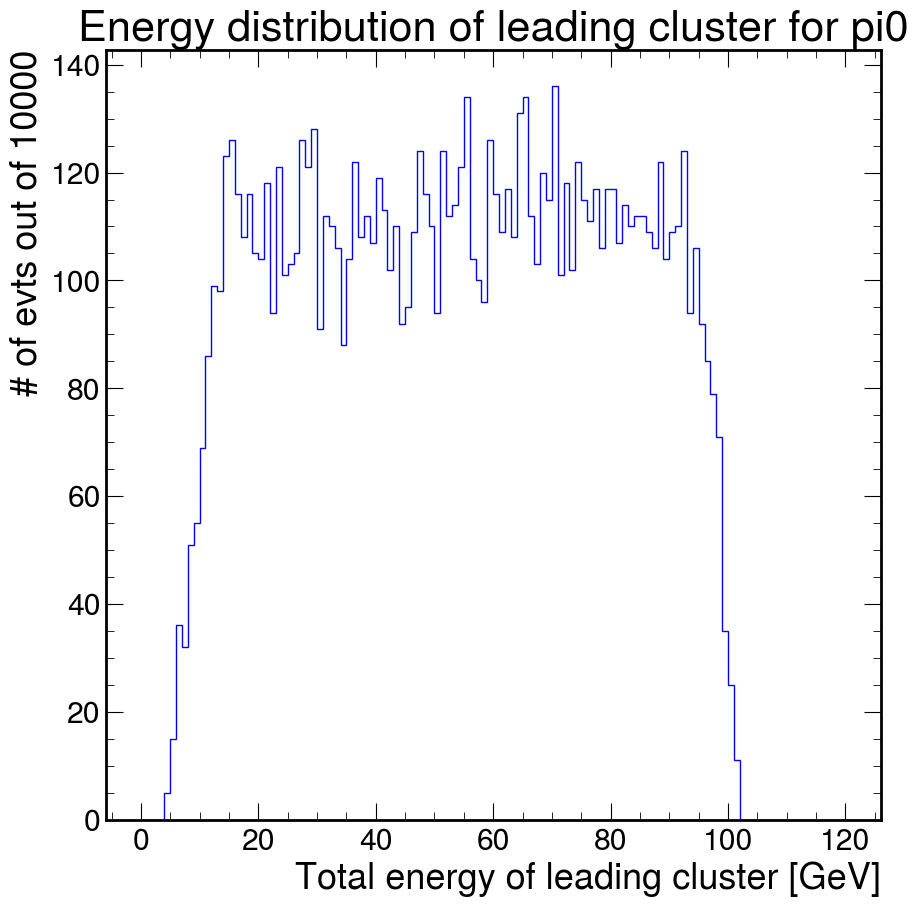

In [29]:
EnergyCluster("st23_pi0_520_10000eve.root")